# Decision Tree Classification on the Moons Dataset

A small, end-to-end **machine learning workflow** (inspired by *Hands-On Machine Learning*, Chapter 6):

1. Generate a noisy, non-linear dataset (`make_moons`)
2. Split into train/test
3. Train a baseline Decision Tree
4. Tune hyperparameters with cross-validation (`GridSearchCV`)
5. Evaluate on the test set
6. Visualize decision boundaries

> **Goal:** learn the workflow and build intuition about **overfitting** and **regularization** for Decision Trees.


## 1) Imports & Reproducibility

We fix a `random_state` so results are repeatable (important for debugging and for GitHub projects).


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, ConfusionMatrixDisplay

RANDOM_STATE = 42


## 2) Data Generation & Quick Exploration

`make_moons` returns:
- `X`: features with shape `(n_samples, 2)`
- `y`: labels (0 or 1)

The `noise` parameter makes the task harder by adding overlap between classes.


In [3]:
X, y = make_moons(n_samples=10_000, noise=0.4, random_state=RANDOM_STATE)

print("X shape:", X.shape)
print("y shape:", y.shape)

unique, counts = np.unique(y, return_counts=True)
print("Class distribution:", dict(zip(unique, counts)))


X shape: (10000, 2)
y shape: (10000,)
Class distribution: {np.int64(0): np.int64(5000), np.int64(1): np.int64(5000)}


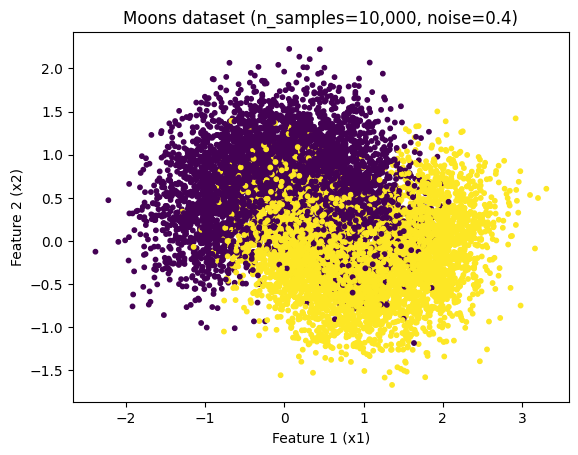

In [4]:
plt.figure()
plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
plt.title("Moons dataset (n_samples=10,000, noise=0.4)")
plt.xlabel("Feature 1 (x1)")
plt.ylabel("Feature 2 (x2)")
plt.show()


## 3) Train–Test Split

We keep the **test set** untouched until the very end to measure generalization.
We also use `stratify=y` to preserve class proportions in both splits.


In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=RANDOM_STATE,
    stratify=y
)

print("Train:", X_train.shape, " Test:", X_test.shape)


Train: (8000, 2)  Test: (2000, 2)


## 4) Baseline Model (Default Decision Tree)

A default Decision Tree often **overfits** noisy data:
- training accuracy becomes very high
- test accuracy is lower

This baseline gives us a reference point before tuning.


In [6]:
baseline_tree = DecisionTreeClassifier(random_state=RANDOM_STATE)
baseline_tree.fit(X_train, y_train)

y_train_pred = baseline_tree.predict(X_train)
y_test_pred = baseline_tree.predict(X_test)

baseline_train_acc = accuracy_score(y_train, y_train_pred)
baseline_test_acc = accuracy_score(y_test, y_test_pred)

print(f"Baseline training accuracy: {baseline_train_acc:.4f}")
print(f"Baseline test accuracy:     {baseline_test_acc:.4f}")


Baseline training accuracy: 1.0000
Baseline test accuracy:     0.7980


## 5) Hyperparameter Tuning with Cross-Validation

We tune `max_leaf_nodes` (as suggested in the book).  
This limits the number of leaves and acts as **regularization** (prevents the tree from growing too complex).

We use 5-fold cross-validation on the training set.


In [7]:
param_grid = {
    "max_leaf_nodes": list(range(2, 101))  # try 2..100
}

grid_search = GridSearchCV(
    estimator=DecisionTreeClassifier(random_state=RANDOM_STATE),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

print("Best params:", grid_search.best_params_)
print(f"Best CV accuracy: {grid_search.best_score_:.4f}")


Best params: {'max_leaf_nodes': 29}
Best CV accuracy: 0.8604


## 6) Final Model (Train on full training set, evaluate on test set)

After selecting the best hyperparameters via CV, we evaluate once on the test set.


In [8]:
best_tree = grid_search.best_estimator_
best_tree.fit(X_train, y_train)

y_test_pred_best = best_tree.predict(X_test)
best_test_acc = accuracy_score(y_test, y_test_pred_best)

print(f"Tuned test accuracy: {best_test_acc:.4f}")

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred_best))


Tuned test accuracy: 0.8620

Classification report (test):
              precision    recall  f1-score   support

           0       0.87      0.86      0.86      1000
           1       0.86      0.87      0.86      1000

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



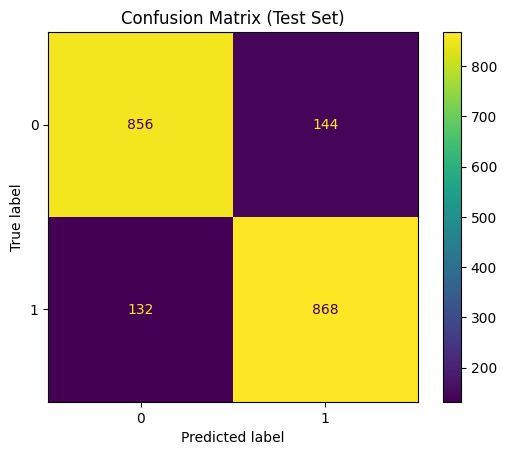

In [9]:
ConfusionMatrixDisplay.from_predictions(y_test, y_test_pred_best)
plt.title("Confusion Matrix (Test Set)")
plt.show()


## 7) Visualizing Decision Boundaries

Decision Trees create **axis-aligned** splits, so boundaries often look like rectangles/steps.

We'll plot boundaries for both:
- baseline tree (likely overfit)
- tuned tree (simpler, better generalization)


In [10]:
def plot_decision_boundary(clf, X, y, title="Decision boundary"):
    x1_min, x1_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    x2_min, x2_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    xx1, xx2 = np.meshgrid(
        np.linspace(x1_min, x1_max, 400),
        np.linspace(x2_min, x2_max, 400)
    )
    X_grid = np.c_[xx1.ravel(), xx2.ravel()]
    preds = clf.predict(X_grid).reshape(xx1.shape)

    plt.figure()
    plt.contourf(xx1, xx2, preds, alpha=0.25)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=10)
    plt.title(title)
    plt.xlabel("Feature 1 (x1)")
    plt.ylabel("Feature 2 (x2)")
    plt.show()


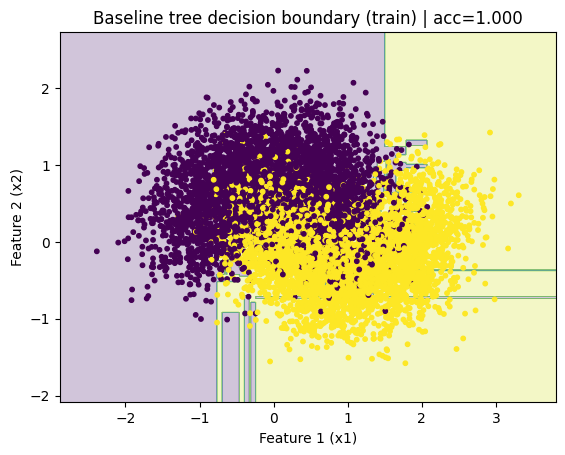

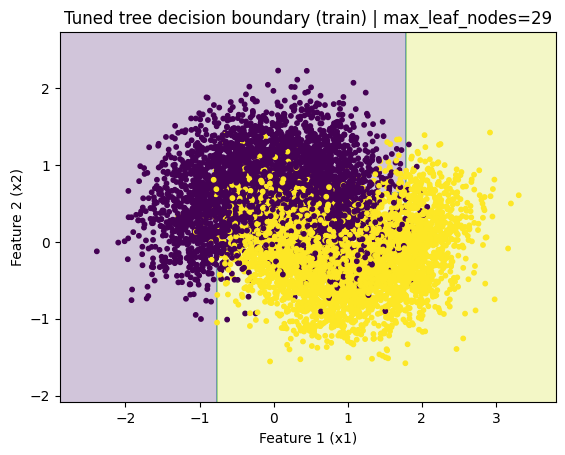

In [11]:
plot_decision_boundary(
    baseline_tree, X_train, y_train,
    title=f"Baseline tree decision boundary (train) | acc={baseline_train_acc:.3f}"
)

plot_decision_boundary(
    best_tree, X_train, y_train,
    title=f"Tuned tree decision boundary (train) | max_leaf_nodes={grid_search.best_params_['max_leaf_nodes']}"
)


## 8) Summary

- Baseline Decision Tree often **overfits** noisy data (high train accuracy, lower test accuracy).
- Limiting complexity with `max_leaf_nodes` improves **generalization**.
- Cross-validation helps choose hyperparameters without peeking at the test set.

### Next steps
- Try additional regularization: `max_depth`, `min_samples_leaf`
- Compare with **RandomForestClassifier** (ensembles reduce instability / variance)
